## Imports

In [1]:
# referenced https://srush.github.io/annotated-s4/#part-1b-addressing-long-range-dependencies-with-hippo

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, datasets
from scipy.signal import fftconvolve
from models._utils import SSM, CTRNN


CUDA device found.


Input signal: (torch.Size([2, 100, 8]), torch.float32)
Target signal: (torch.Size([2, 100]), torch.float32)
Output signal: (torch.Size([2, 100]), torch.float32)



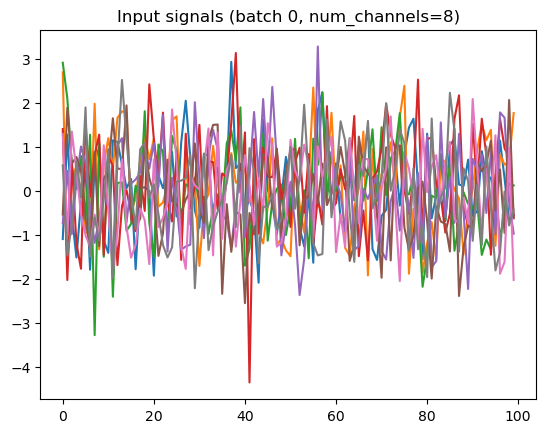

Epoch: 0 	 Loss: 0.540366530418396

step gradient: 0.4378892481327057
A.weight gradient: None
B.weight gradient: 0.36977967619895935

Epoch: 1 	 Loss: 0.49151092767715454
Epoch: 2 	 Loss: 0.45119190216064453
Epoch: 3 	 Loss: 0.41625475883483887
Epoch: 4 	 Loss: 0.38520967960357666
Epoch: 5 	 Loss: 0.35751187801361084
Epoch: 6 	 Loss: 0.33344146609306335
Epoch: 7 	 Loss: 0.31345799565315247
Epoch: 8 	 Loss: 0.2977949380874634
Epoch: 9 	 Loss: 0.28628894686698914
Epoch: 10 	 Loss: 0.277828574180603
Epoch: 11 	 Loss: 0.2702578604221344
Epoch: 12 	 Loss: 0.26153331995010376
Epoch: 13 	 Loss: 0.25110316276550293
Epoch: 14 	 Loss: 0.23998385667800903
Epoch: 15 	 Loss: 0.2298019826412201
Epoch: 16 	 Loss: 0.22162793576717377
Epoch: 17 	 Loss: 0.21534867584705353
Epoch: 18 	 Loss: 0.2100568562746048
Epoch: 19 	 Loss: 0.20487327873706818
Epoch: 20 	 Loss: 0.1995069533586502


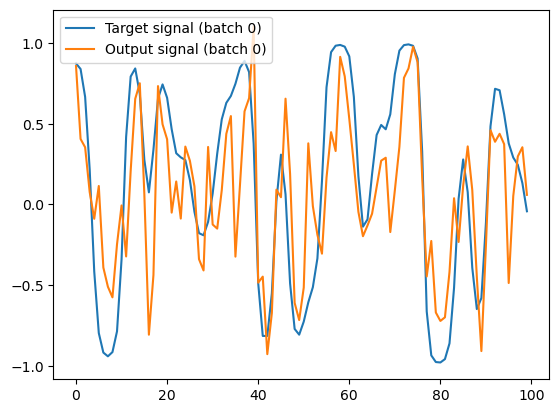

In [2]:
model_dim = 50
timesteps = 100
num_channels = 8
batch_size = 2
epochs = 20

model = SSM(input_size=num_channels, hidden_size=model_dim) 
# model = CTRNN(input_size=num_channels, hidden_size=model_dim) 

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

input_signal = torch.randn((batch_size, timesteps, num_channels))
print(f'Input signal: {input_signal.shape, input_signal.dtype}')

kernel = signal.windows.gaussian(15, 2)
kernel = kernel / kernel.sum()
target_signal = torch.from_numpy(np.stack([np.stack([signal.fftconvolve(input_signal[b,:,c].numpy(), kernel, mode='same') 
                                                     for c in range(num_channels)], axis=-1) 
                                                     for b in range(batch_size)], axis=0)).to(dtype=input_signal.dtype).sum(dim=-1).tanh()
print(f'Target signal: {target_signal.shape, target_signal.dtype}')

output_signal, hidden_state = model(input_signal)
output_signal = output_signal.sum(dim=-1)
print(f'Output signal: {output_signal.shape, output_signal.dtype}\n')

plt.plot(input_signal[0,:,:].numpy())
plt.title("Input signals (batch 0, num_channels=8)")
plt.show()

optimizer.zero_grad()
loss = criterion(output_signal, target_signal)
print(f"Epoch: 0 \t Loss: {loss.item()}")
loss.backward()
optimizer.step()

print()
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} gradient: {param.grad.norm().item()}")
    else:
        print(f"{name} gradient: None")
print()

for i in range(epochs):
    output_signal, hidden_state = model(input_signal)
    output_signal = output_signal.sum(dim=-1)

    optimizer.zero_grad()
    loss = criterion(output_signal, target_signal)
    print(f"Epoch: {i+1} \t Loss: {loss.item()}")
    loss.backward()
    optimizer.step()

plt.plot(target_signal[0,:].numpy(), label="Target signal (batch 0)")
plt.plot(output_signal[0,:].detach().numpy(), label="Output signal (batch 0)")
plt.legend()
plt.show()
